## LOBSTER-ECOL GLORYs Surface and Bottom Temperature Processing

Processing zonal timeseries of surface and bottom temperatures from the GLORYs ocean reanalysis product.

In [1]:

####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np
import geopandas as gpd
import regionmask

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal/"
# glorys_path = "../GLORYS_data/"
fpaths_glorys = os.listdir(glorys_path)

In [2]:
# Check files are there
#os.listdir("../GLORYS_data")
fpaths_glorys[0:6]

['CMEMS_Northeast_TempSal_2011_02.nc',
 'CMEMS_Northeast_TempSal_2022_01.nc',
 'CMEMS_Northeast_TempSal_1997_11.nc',
 'CMEMS_Northeast_TempSal_1999_12.nc',
 'CMEMS_Northeast_TempSal_1995_05.nc',
 'CMEMS_Northeast_TempSal_2008_12.nc']

In [3]:
# Open one file to get depth indices
glorys_single = xr.open_mfdataset(f"{glorys_path}{fpaths_glorys[0]}", combine = "by_coords", parallel = True)
glorys_single

<xarray.Dataset> Size: 508MB
Dimensions:    (depth: 38, latitude: 132, longitude: 226, time: 28)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude  (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time       (time) datetime64[ns] 224B 2011-02-01 2011-02-02 ... 2011-02-28
Data variables:
    thetao     (time, depth, latitude, longitude) float64 254MB dask.array<chunksize=(28, 38, 132, 226), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 254MB dask.array<chunksize=(28, 38, 132, 226), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.1

<Axes: >

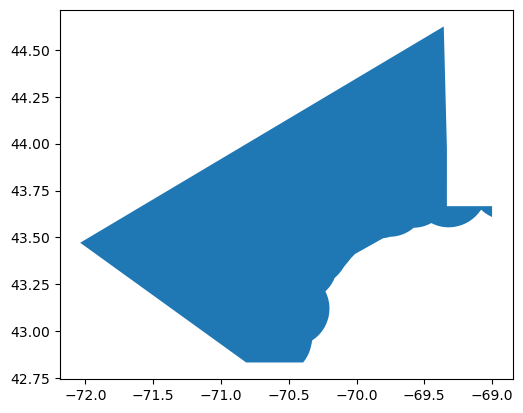

In [4]:
# Load Shapefiles into Lists

# Load Inshore masks
inshore_path = f"{lobecol_path}inshore_areas/"
inshore_areas = os.listdir(inshore_path)
inshore_names = []
inshore_polys = []
for area in inshore_areas:
    inshore_names.append(area.removesuffix(".geojson"))
    inshore_polys.append(gpd.read_file(f"{inshore_path}{area}"))


# Load offshore areas
offshore_path = f"{lobecol_path}offshore_areas/"
offshore_areas = os.listdir(offshore_path)
offshore_names = []
offshore_polys = []
for area in offshore_areas:
    offshore_names.append(area.removesuffix(".geojson"))
    offshore_polys.append(gpd.read_file(f"{offshore_path}{area}"))


# Convert lists to dictionary
inshore_poly_dict = {inshore_names[i]: inshore_polys[i] for i in range(len(inshore_names))}
offshore_poly_dict = {offshore_names[i]: offshore_polys[i] for i in range(len(offshore_names))}
    

# Plot inshore
inshore_poly_dict["513-Western_Maine"].plot()

# # Plot Offshore
# offshore_poly_dict["SNE"].plot()

# Pull Surface and Bottom Out of everything

The following function will take an xarray dataset with some arguments and identify the maximum depth dimension index that holds non-NA values of some variable. These indices can then be used to extract values at those depths, which should correspond with "bottom" values. 


In [5]:
# Identify Bottom Indices
# find bottom temp for any netcdf with depth
def find_deepest_depth_indices(ds, variable_id, y_coord, x_coord, depth_coord, maxDepth = 2000):


    # Subset up to an optional max depth
    kwargs = {depth_coord: slice(0, maxDepth)}
    bottom_400 = ds.sel(**kwargs)

    # First get the vertical True/False of valid values
    idx = bottom_400[variable_id].isel(time=0).isnull()
    idx_vals = idx.values


    if len(bottom_400[variable_id][x_coord].dims) == 2:
        multiIndex = True
    else:
        multiIndex = False

    if multiIndex == True:
        dims0 = bottom_400[y_coord].dims[0]
        dims1 = bottom_400[y_coord].dims[1]
    else:
        dims0 = y_coord
        dims1 = x_coord


    # Create the initial final array to store indices (integer type)
    depth_indices = np.zeros((len(idx[y_coord][dims0]), len(idx[x_coord][dims1]))).astype(int)

    # Now find the deepest depth where values are True and store in indices array
    for i in range(len(bottom_400[dims1].values)):
        for j in range(len(bottom_400[dims0].values)):
            located = np.where(idx_vals[:, j, i] == False)
            try:
                depth_indices[j, i] = int(located[-1][-1])
            except IndexError:
                depth_indices[j, i] = 1

    # Gather as a DataArray
    ind = xr.DataArray(depth_indices, dims=[dims0, dims1])

    return ind


In [6]:
# Load all of the Glorys year as one file

# Load GLORYs
fpaths_glorys_full = []
for file in fpaths_glorys:
    fpaths_glorys_full.append(f"{glorys_path}{file}")
# fpaths_glorys_full[0:6]

# # Lazy-load the data itself using xr.open_mfdataset
glorys_all = xr.open_mfdataset(fpaths_glorys_full, combine = "by_coords", parallel = True)
glorys_all

<xarray.Dataset> Size: 205GB
Dimensions:    (time: 11322, depth: 38, latitude: 132, longitude: 226)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude  (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time       (time) datetime64[ns] 91kB 1993-01-01 1993-01-02 ... 2023-12-31
Data variables:
    thetao     (time, depth, latitude, longitude) float64 103GB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 103GB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.1

## Get Indices for "Bottom" Layer

Use that to pull the proper depth slices from the full array.

In [7]:
# Pull the bottom indices from the single glorys file
glorys_bottom_idx = find_deepest_depth_indices(
    ds = glorys_single, 
    variable_id = 'thetao', 
    x_coord = 'longitude', 
    y_coord = 'latitude', 
    depth_coord = 'depth', 
    maxDepth = 1600)

## Pull the Data at the "Bottom" Indices Across Time

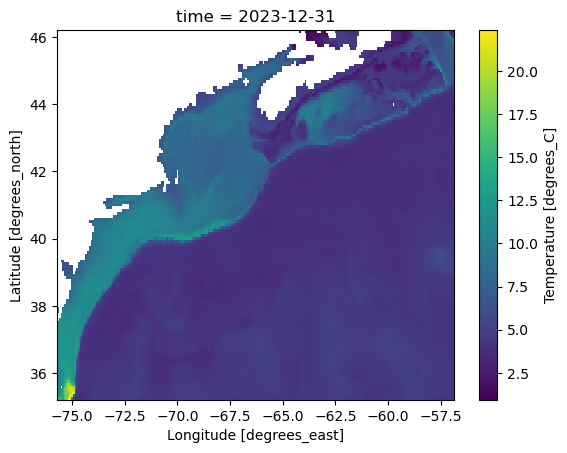

In [8]:
# Use that to extract the variables we care about

# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_bottom_idx}
var_array = glorys_all['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel.to_dataset()
ds.thetao.isel(time = -1).plot()

### TESTING: Mask Values where Depth was* Greater than Max Depth

The Glorys data was downloaded to a max depth of 1500m. So the indices returned in the previous step are returning true bottom layer indices for areas shallower than 1500m, but for areas deeper than this it is returning a "false bottom" of 1500m.

This was never sorted out, what we did instead is change the shapefile to only cover depths shallower than 1500m.

In [9]:
# Get/Make Mask?
# masked_depth = glorys_single.thetao.where(glorys_single.depth >= 1500, np.nan)


### Prepare xr.Datasets for Region Masking

Just reorganizing and renaming variables so that they can be joined easily later.

In [10]:
# Refocus/Reshape
surface_ds = glorys_all.thetao.isel(depth = 0).to_dataset().rename_vars({"thetao" : "surface_temp"})
bottom_ds = ds.rename_vars({"thetao" : "bottom_temp"})
bottom_ds

<xarray.Dataset> Size: 3GB
Dimensions:      (latitude: 132, longitude: 226, time: 11322)
Coordinates:
    depth        (latitude, longitude) float32 119kB 7.93 7.93 ... 55.76 55.76
  * latitude     (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude    (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time         (time) datetime64[ns] 91kB 1993-01-01 1993-01-02 ... 2023-12-31
Data variables:
    bottom_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(31, 132, 226), meta=np.ndarray>

# Cropping to the Inshore Areas, Reshape as Timeseries

From here we can loop through the inshore areas and mask out their values. The following function will perform regional masking of an xarray dataset for a target variable, returning a pandas dataframe.

In [11]:
# Function to mask
def calc_ts_mask(grid_obj, shp_obj, shp_name, var_name = "sst"):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
    var_name (str) : Optional string identifying the variable to use
    climatology (bool): Whether you are masking a climatology, informs naming conventions and
    whether to process standard deviation
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(
    shp_obj.geometry,
    name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  # mask = area_mask.mask(grid_obj, lon_name = "longitude", lat_name = "latitude")
  mask = area_mask.mask(grid_obj["longitude"], grid_obj["latitude"])

  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  #### 4. Calculate timeseries mean

  # Not area-weighted
  masked_ts = getattr(masked_ds, var_name).mean(dim = ("latitude", "longitude"))

  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()
  masked_ts_df = masked_ts_df.reset_index()[["time", f"{var_name}"]]
    
  # Return the table as output
  return masked_ts_df

## Perform Masking on Inshore/Offshore Areas

The following code will loop through the regions and process regional means of surface and bottom temperatures.

In [12]:
# list to store the inshore region timeseries
inshore_ts = []  # Inshore area timeseries

# Iterate through names and shapes simultaneously
for mask_shp, mask_name in zip(inshore_polys, inshore_names):
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = surface_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = bottom_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time")

    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    inshore_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")

513-Western_Maine timeseries processed.
513-Western_Maine timeseries processed.


611-Long_Island_Sound timeseries processed.
611-Long_Island_Sound timeseries processed.


612-Cholera_Bank timeseries processed.
612-Cholera_Bank timeseries processed.


537-Off_No_Mans_Land timeseries processed.
537-Off_No_Mans_Land timeseries processed.


512-Central_Maine timeseries processed.
512-Central_Maine timeseries processed.


539-Rhode_Island_Shore timeseries processed.
539-Rhode_Island_Shore timeseries processed.


625-No_Carolina_Shore timeseries processed.
625-No_Carolina_Shore timeseries processed.


614-New_Jersey_Shore timeseries processed.
614-New_Jersey_Shore timeseries processed.


621-Five_Fathom_Bank timeseries processed.
621-Five_Fathom_Bank timeseries processed.


511-Eastern_Maine timeseries processed.
511-Eastern_Maine timeseries processed.


526-Nantucket_Shoals timeseries processed.
526-Nantucket_Shoals timeseries processed.


538-Southern_Mass timeseries processed.
538-Southern_Mass timeseries processed.


615-Barnegat_Ridge timeseries processed.
615-Barnegat_Ridge timeseries processed.


613-Off_Long_Island timeseries processed.
613-Off_Long_Island timeseries processed.


514-Eastern_Mass timeseries processed.
514-Eastern_Mass timeseries processed.


625-Virginia_Shore timeseries processed.
625-Virginia_Shore timeseries processed.


521-W_South_Channel timeseries processed.
521-W_South_Channel timeseries processed.


In [14]:
# Check one
print(inshore_names[3])
inshore_ts[3].head()

537-Off_No_Mans_Land
537-Off_No_Mans_Land


,time,surface_temp,bottom_temp
0,1993-01-01,6.111760,6.127294
1,1993-01-02,5.802361,5.966872
2,1993-01-03,5.472165,5.680673
3,1993-01-04,5.621993,5.738843
4,1993-01-05,6.284003,6.296574


<Axes: xlabel='time'>

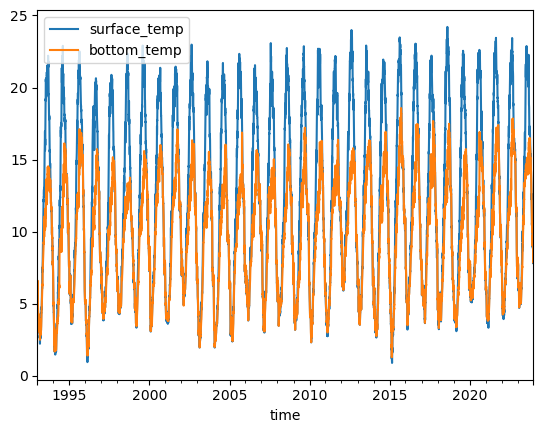

In [15]:
inshore_ts[3].plot("time")

## Process Offshore Regions

Do the same thing for the two broader offshore areas: Gulf of Maine + Georges Bank, & Southern New England

In [16]:
# list to store the inshore region timeseries
offshore_ts = []  # Inshore area timeseries

# Iterate through names and shapes simultaneously
for mask_shp, mask_name in zip(offshore_polys, offshore_names):
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = surface_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = bottom_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")
    
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time")

    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    offshore_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")

GOM_GBK timeseries processed.
GOM_GBK timeseries processed.


SNE timeseries processed.
SNE timeseries processed.


In [19]:
# Check one
print(offshore_names[0])
offshore_ts[0].head()

GOM_GBK
GOM_GBK


,time,surface_temp,bottom_temp
0,1993-01-01,6.728279,7.466552
1,1993-01-02,6.601795,7.445424
2,1993-01-03,6.462830,7.396705
3,1993-01-04,6.452267,7.363688
4,1993-01-05,6.546958,7.391266


<Axes: xlabel='time'>

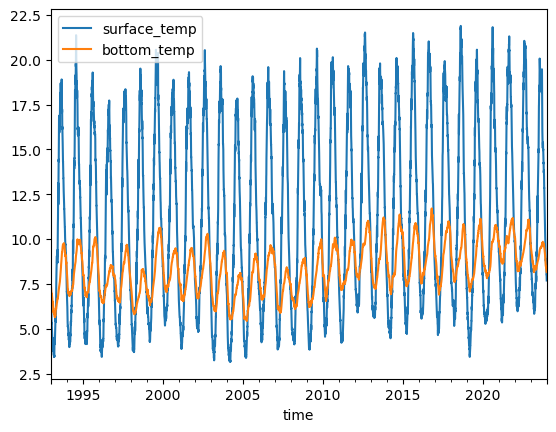

In [20]:
offshore_ts[0].plot("time")

## What Does the Entire Area Resemble?

In [21]:
# This looks so weird...
#glorys_all.thetao.mean(dim = ("longitude", "latitude")).plot()
glorys_all.time

<xarray.DataArray 'time' (time: 11322)> Size: 91kB
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2023-12-29T00:00:00.000000000',
       '2023-12-30T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 91kB 1993-01-01 1993-01-02 ... 2023-12-31
Attributes:
    valid_min:  376944
    valid_max:  377664

# Save timeseries for Inspection

In [22]:
# Save Inshore Data Locally
for region_ts, region_name in zip(inshore_ts, inshore_names):
    #os.listdir("../local_data")
    region_ts.to_csv(f"../local_data/inshore_timeseries/GLORYs_surfbottemp_{region_name}.csv")


# Save Offshore Data Locally
for region_ts, region_name in zip(offshore_ts, offshore_names):
    #os.listdir("../local_data")
    region_ts.to_csv(f"../local_data/offshore_timeseries/GLORYs_surfbottemp_{region_name}.csv")